# Capstone Project, by Anna Mitchell

## Neural Machine Translation
### English to German 

In [1]:
import collections
import numpy as np
import pandas as pd

import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [3]:
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

#### Sources 

In [4]:
#Code help and adaption for this project come from the following resources:

#https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
#https://towardsdatascience.com/neural-machine-translation-with-python-c2f0a34f7dd
#https://www.tensorflow.org/tutorials/text/nmt_with_attention
#https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/
#https://google.github.io/seq2seq/nmt/
#https://opennmt.net/
#https://stackoverflow.com/questions/tagged/machine-translation

### Clean Text

In [46]:
# load doc into memory
# load data to preserve unicode german characters, loads file as a blob of text
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [47]:
# split a loaded document into sentences
def pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [48]:
# clean a list of lines
# remove non printable characters
# remove all punctuation characters
# normalize all unicode characters to ASCII
#normalize the case to lower
#remove any remaining tokens that are not alphabetic 
#perform these operations on each phrase for each pair in the loaded dataset.

def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [49]:
# save a list of clean sentences to file
def clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

#### Dataset Source: http://www.manythings.org/

In [50]:
# load dataset
filename = 'deu1.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
clean_data(clean_pairs, 'english-german.pkl')

Saved: english-german.pkl


In [51]:
# check if working
for i in range(50):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

[go] => [geh]
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[wait] => [warte]
[begin] => [fang an]
[go on] => [mach weiter]
[hello] => [hallo]
[hurry] => [beeil dich]
[hurry] => [schnell]
[i hid] => [ich versteckte mich]
[i hid] => [ich habe mich versteckt]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[relax] => [entspann dich]
[shoot] => [feuer]
[shoot] => [schie]
[smile] => [lacheln]
[ask me] => [frag mich]
[ask me] => [fragt mich]
[ask me] => [fragen sie mich]
[attack] => [angriff]
[attack] => [attacke]
[cheers] => [zum wohl]
[eat it] => [iss es]
[eat up] => [iss auf]
[eat up] => [iss auf]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[go now] => [geh jetzt]
[got it] => [verstanden]
[got it] => [aha]
[got 

### Split Text

In [52]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# save a list of clean sentences to file
def clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
clean_data(dataset, 'english-german-both.pkl')
clean_data(train, 'english-german-train.pkl')
clean_data(test, 'english-german-test.pkl')

#both.pkl - contains all of the train and test examples that we can use to 
#-> define the parameters of the problem, such a smax phrase lengths and the vocab
# train.pkl and test.pkl - train and test dataset 

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


#### Text to Sequence Conversion

In [53]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [54]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [55]:
data = read_text("deu1.txt")
ger_eng = to_lines(data)
ger_eng = array(ger_eng)

In [56]:
ger_eng = ger_eng[:50000,:]

In [57]:
# Remove punctuation
ger_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ger_eng[:,0]]
ger_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ger_eng[:,1]]

In [58]:
# convert to lowercase
for i in range(len(ger_eng)):
    ger_eng[i,0] = ger_eng[i,0].lower()
    
    ger_eng[i,1] = ger_eng[i,1].lower()

In [59]:
# empty lists
eng_l = []
ger_l = []

# populate the lists with sentence lengths
for i in ger_eng[:,0]:
    eng_l.append(len(i.split()))

for i in ger_eng[:,1]:
    ger_l.append(len(i.split()))

In [60]:
length_df = pd.DataFrame({'english':eng_l, 'german':ger_l})

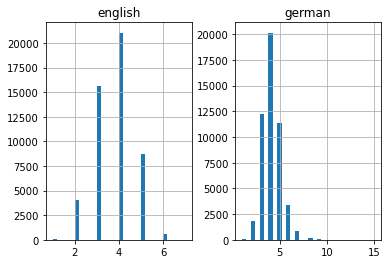

In [61]:
length_df.hist(bins = 30)
plt.show()

In [62]:
#Maximum length of German: 11
#Maxiumum lenght of English: 6

In [63]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [64]:
# english tokenizer
eng_tokenizer = tokenization(ger_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6243


In [65]:
# German tokenizer
ger_tokenizer = tokenization(ger_eng[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1

ger_length = 8
print('German Vocabulary Size: %d' % ger_vocab_size)

German Vocabulary Size: 10329


### Train Neural Translation Model

* Optimizer: rmsprop 
* Loss: categorical_crossentropy
* Epochs: 30
* Batch size: 64

In [66]:
#develop neural translation model
#load and prepare clean text data ready for modeling and define and train the model
#-> on the prepared data 

In [67]:
#code adapted from https://medium.com/@umerfarooq_26378/neural-machine-translation-with-code-68c425044bbd

In [77]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    #core layer, encodes the input by indices 
    #If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1) per keras library.
    model.add(LSTM(n_units))
    #recurrent layer to choose different implementation to maximize performance 
    model.add(RepeatVector(tar_timesteps))
    #reshaping layer to repeat the input by a specific amount of times 
    model.add(LSTM(n_units, return_sequences=True))
     #recurrent layer to choose different implementation to maximize performance 
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    #activation layer, wrapper to apply a layer to every temporal slice of an input 
    return model
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
 
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
 
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])
# summarize defined model
print(model.summary())
#plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 2241
English Max Length: 5
German Vocabulary Size: 3572
German Max Length: 9
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 9, 256)            914432    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 2241)           575937    
Total params: 2,540,993
Trainable params: 2,540,993
Non-trainable params: 0
_________________________________________________________________
None
Epo

In [89]:
results = model.evaluate(trainX, trainY, verbose=0)
results

[0.36544615030288696, 0.9199555516242981]

In [79]:
#Accuracy of 92%

### Display loss and accuracy

#### Plot the training and validation loss

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [81]:
epochs = range(1, len(loss) + 1)

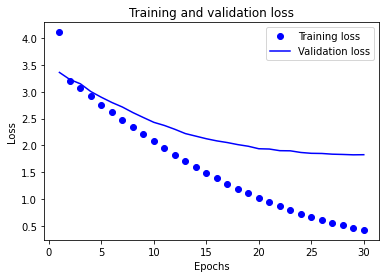

In [82]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

#### Plot the training and validation accuracy

In [86]:
#clear the figure, palette cleanser, if you will :)
plt.clf();

<Figure size 432x288 with 0 Axes>

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

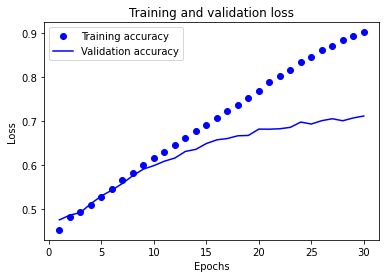

In [88]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### Train again

* Optimizer: Adam 
* Loss: categorical_crossentropy
* Epochs: 10
* Batch size: 80

In [93]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    #core layer, encodes the input by indices 
    #If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1) per keras library.
    model.add(LSTM(n_units))
    #recurrent layer to choose different implementation to maximize performance 
    model.add(RepeatVector(tar_timesteps))
    #reshaping layer to repeat the input by a specific amount of times 
    model.add(LSTM(n_units, return_sequences=True))
     #recurrent layer to choose different implementation to maximize performance 
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    #activation layer, wrapper to apply a layer to every temporal slice of an input 
    return model
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
 
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
 
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# summarize defined model
print(model.summary())
#plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history2 = model.fit(trainX, trainY, epochs=10, batch_size=80, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 2241
English Max Length: 5
German Vocabulary Size: 3572
German Max Length: 9
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 9, 256)            914432    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 2241)           575937    
Total params: 2,540,993
Trainable params: 2,540,993
Non-trainable params: 0
_________________________________________________________________
None
Epo

In [94]:
results = model.evaluate(trainX, trainY, verbose=0)
results

[2.1415884494781494, 0.6006222367286682]

* Accurracy is way lower

### Train again

* Optimizer: rmsprop 
* Loss: categorical_crossentropy
* Epochs: 50
* Batch Size: 50

In [97]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    #core layer, encodes the input by indices 
    #If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1) per keras library.
    model.add(LSTM(n_units))
    #recurrent layer to choose different implementation to maximize performance 
    model.add(RepeatVector(tar_timesteps))
    #reshaping layer to repeat the input by a specific amount of times 
    model.add(LSTM(n_units, return_sequences=True))
     #recurrent layer to choose different implementation to maximize performance 
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    #activation layer, wrapper to apply a layer to every temporal slice of an input 
    return model
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))
 
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)
 
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# summarize defined model
print(model.summary())
#plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history2 = model.fit(trainX, trainY, epochs=50, batch_size=50, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 2241
English Max Length: 5
German Vocabulary Size: 3572
German Max Length: 9
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 9, 256)            914432    
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 2241)           575937    
Total params: 2,540,993
Trainable params: 2,540,993
Non-trainable params: 0
_________________________________________________________________
None
Epo

In [98]:
results = model.evaluate(trainX, trainY, verbose=0)
results

[0.0913555771112442, 0.9636889100074768]

* Best accuracy overall!

### Evaluate Neural Translation Model

In [99]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [100]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

In [101]:
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])

In [102]:
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

### Save my NN model to YAML

In [103]:
#code help from https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a

In [104]:
from keras.models import model_from_yaml
import os

In [105]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [106]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [107]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)

In [108]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [109]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 96.37%


In [110]:
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [111]:
# load model
model = load_model('model.h5')

In [112]:
#Next repeat this for each source phrase in a dataset and 
#-> compare the predicted result to the expected target phrase in English.

In [113]:
#code help from #https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

In [114]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
 
# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[ich bin ungeduldig], target=[im impatient], predicted=[im impatient]
src=[wie seltsam], target=[how strange], predicted=[how strange]
src=[ich bin nicht schuchtern], target=[im not shy], predicted=[im not shy]
src=[ich brauche eine jacke], target=[i need a coat], predicted=[i need a coat]
src=[ich habe tom getroffen], target=[i met tom], predicted=[ive seen tom]
src=[ich habe tom verachtet], target=[i despised tom], predicted=[i despised tom]
src=[wir sind sauber], target=[were clean], predicted=[were clean]
src=[tom wurde gefeuert], target=[tom got fired], predicted=[tom was fired]
src=[konnen sie mir folgen], target=[do you follow], predicted=[do you follow]
src=[entlassen wir tom], target=[lets fire tom], predicted=[lets fire tom]
BLEU-1: 0.945465
BLEU-2: 0.927995
BLEU-3: 0.841743
BLEU-4: 0.513061
test
src=[das ist nicht okay], target=[thats not ok], predicted=[thats not ok]
src=[das ist besser], target=[this is better], predicted=[thats better]
src=[ich ergebe mich], tar

### Make Predictions on unseen data

In [115]:
#code help from https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/

In [116]:
model = load_model('model.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [117]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [118]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [119]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [120]:
pd.set_option('display.max_colwidth', 200)

In [121]:
pred_df.head(15)

,actual,predicted
0,thats not ok,thats not ok
1,this is better,thats better
2,i surrender,i fell me
3,please open it,please stop
4,i missed you,we know you
5,go away,beat away
6,is it a secret,is
7,it isnt good,its not good
8,i ran outside,i fired out
9,it gets worse,it gets worse


In [122]:
pred_df.sample(15)

,actual,predicted
469,are you alone,are you lonely
933,tom is special,tom is
405,keep singing,go on
459,he was lucky,he was lucky
406,take my car,no my car
510,get on in here,come inside
714,tom sent me,tom beat me
557,well survive,well will
250,dont panic,dont hurt
396,it happened,its happened
